In [181]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [182]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [183]:
print(device)

cuda


In [184]:
from google.colab import drive
drive.mount('/content/test')

Drive already mounted at /content/test; to attempt to forcibly remount, call drive.mount("/content/test", force_remount=True).


In [185]:
transformer=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [186]:
batch_size = 32
num_classes = 3
learning_rate = 0.001
num_epochs = 10

In [187]:
train_path='/content/test/MyDrive/train'
test_path='/content/test/MyDrive/test'
validation_path = '/content/test/MyDrive/validation'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [188]:
test_loader.dataset[0][0].shape

torch.Size([3, 128, 128])

In [189]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [190]:
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [191]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [192]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = VGG16(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [193]:
import numpy as np
epochs = 30
min_valid_loss = np.inf
val_losses = []
train_losses = []
for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
  

    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validation_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
        
 

    train_losses.append((train_loss / len(train_loader)))
    val_losses.append((valid_loss / len(validation_loader)))


    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')



 

Epoch 1 		 Training Loss: 3.008256135564862 		 Validation Loss: 4.474449157714844
Validation Loss Decreased(inf--->22.372246) 	 Saving The Model
Epoch 2 		 Training Loss: 1.0410471107020522 		 Validation Loss: 1.1781880855560303
Validation Loss Decreased(22.372246--->5.890940) 	 Saving The Model
Epoch 3 		 Training Loss: 1.0283225070346484 		 Validation Loss: 1.0870329141616821
Validation Loss Decreased(5.890940--->5.435165) 	 Saving The Model
Epoch 4 		 Training Loss: 1.0198283376115742 		 Validation Loss: 0.9550722241401672
Validation Loss Decreased(5.435165--->4.775361) 	 Saving The Model
Epoch 5 		 Training Loss: 1.017476322072925 		 Validation Loss: 0.9531028866767883
Validation Loss Decreased(4.775361--->4.765514) 	 Saving The Model
Epoch 6 		 Training Loss: 1.009988251960639 		 Validation Loss: 0.8956571817398071
Validation Loss Decreased(4.765514--->4.478286) 	 Saving The Model
Epoch 7 		 Training Loss: 1.0021016272631558 		 Validation Loss: 1.0678179264068604
Epoch 8 		 Traini

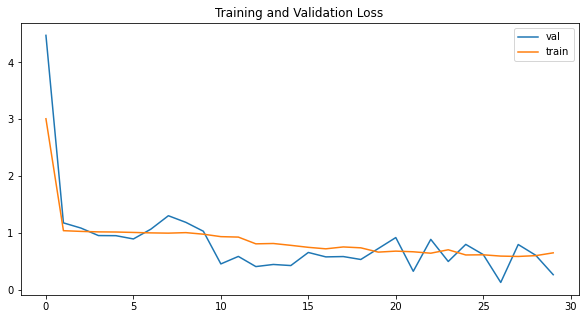

[4.474449157714844, 1.1781880855560303, 1.0870329141616821, 0.9550722241401672, 0.9531028866767883, 0.8956571817398071, 1.0678179264068604, 1.3037229776382446, 1.1872844696044922, 1.0306546688079834, 0.45664453506469727, 0.5884349942207336, 0.4099431037902832, 0.44707006216049194, 0.427945613861084, 0.6580492854118347, 0.5803279280662537, 0.5861124992370605, 0.5345989465713501, 0.7269145846366882, 0.9200475811958313, 0.32686665654182434, 0.8883565664291382, 0.4993289113044739, 0.7999686002731323, 0.6206624507904053, 0.1310179978609085, 0.7978197932243347, 0.6086878180503845, 0.26725441217422485]


In [194]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.legend()
plt.show()


print(val_losses)

In [198]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = VGG16(num_classes=3).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [199]:
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

total_step = len(train_loader)
for epoch in range(27):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                       
y_true = []
y_pred = []

for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())
f1_score(y_true, y_pred, average='macro')
print(f1_score(y_true, y_pred, average='macro'))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 

100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


0.8982219807841133
Accuracy of the network on the 10000 test images: 89.84375 %


In [201]:
import sklearn.metrics

print("f1 score",f1_score(y_true, y_pred, average='macro'))
print("f1 score",f1_score(y_true, y_pred, average='micro'))
print("accuracy_score",sklearn.metrics.accuracy_score(y_true, y_pred))
print("balanced accuracy_score",sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
print("precision_score",sklearn.metrics.precision_score(y_true, y_pred, average='macro'))
print("rECALL micro",sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print("rECALL macro",sklearn.metrics.recall_score(y_true, y_pred, average='macro'))

f1 score 0.8912166035263746
f1 score 0.890625
accuracy_score 0.890625
balanced accuracy_score 0.8903654485049834
precision_score 0.8954998476737607
rECALL micro 0.890625
rECALL macro 0.8903654485049834


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


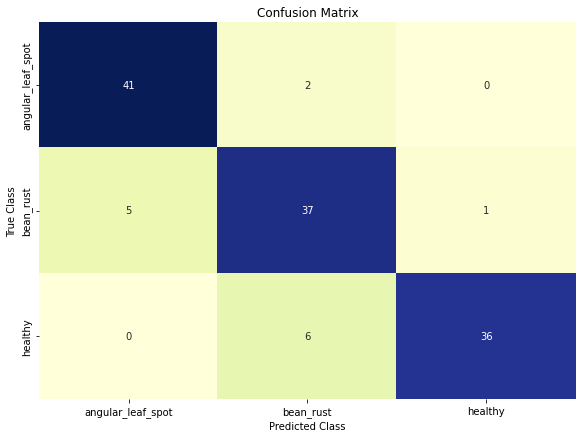

In [200]:
import seaborn as sns
from tqdm import tqdm
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
 
for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())


cf_matrix = confusion_matrix(y_true, y_pred)

class_names = ('angular_leaf_spot', 'bean_rust', 'healthy')
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)


plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()